<a href="https://colab.research.google.com/github/hamzafarooq/multi-agent-course/blob/main/Module_2/Quantization/Bitsnbytes_4bit_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to switch to A100 if running in Colab Environment


## Bitsandbytes 4-bit Quantization

This notebook provides a comprehensive guide on utilizing the `bitsandbytes` library for 4-bit quantization of large language models within the Hugging Face ecosystem. 4-bit quantization is a powerful technique that drastically reduces the memory footprint of models, enabling their deployment and fine-tuning on hardware with limited resources, such as consumer-grade GPUs or Google Colab's T4 instances.

By the end of this notebook, you will be able to:
- Load and run a model quantized to 4 bits.
- Understand and configure advanced 4-bit quantization settings.
- See an example of loading a very large model using 4-bit quantization.
- Push your quantized model to the Hugging Face Hub.


**Note:** Make sure to switch to a GPU runtime (preferably A100 if available in Colab) for faster execution.

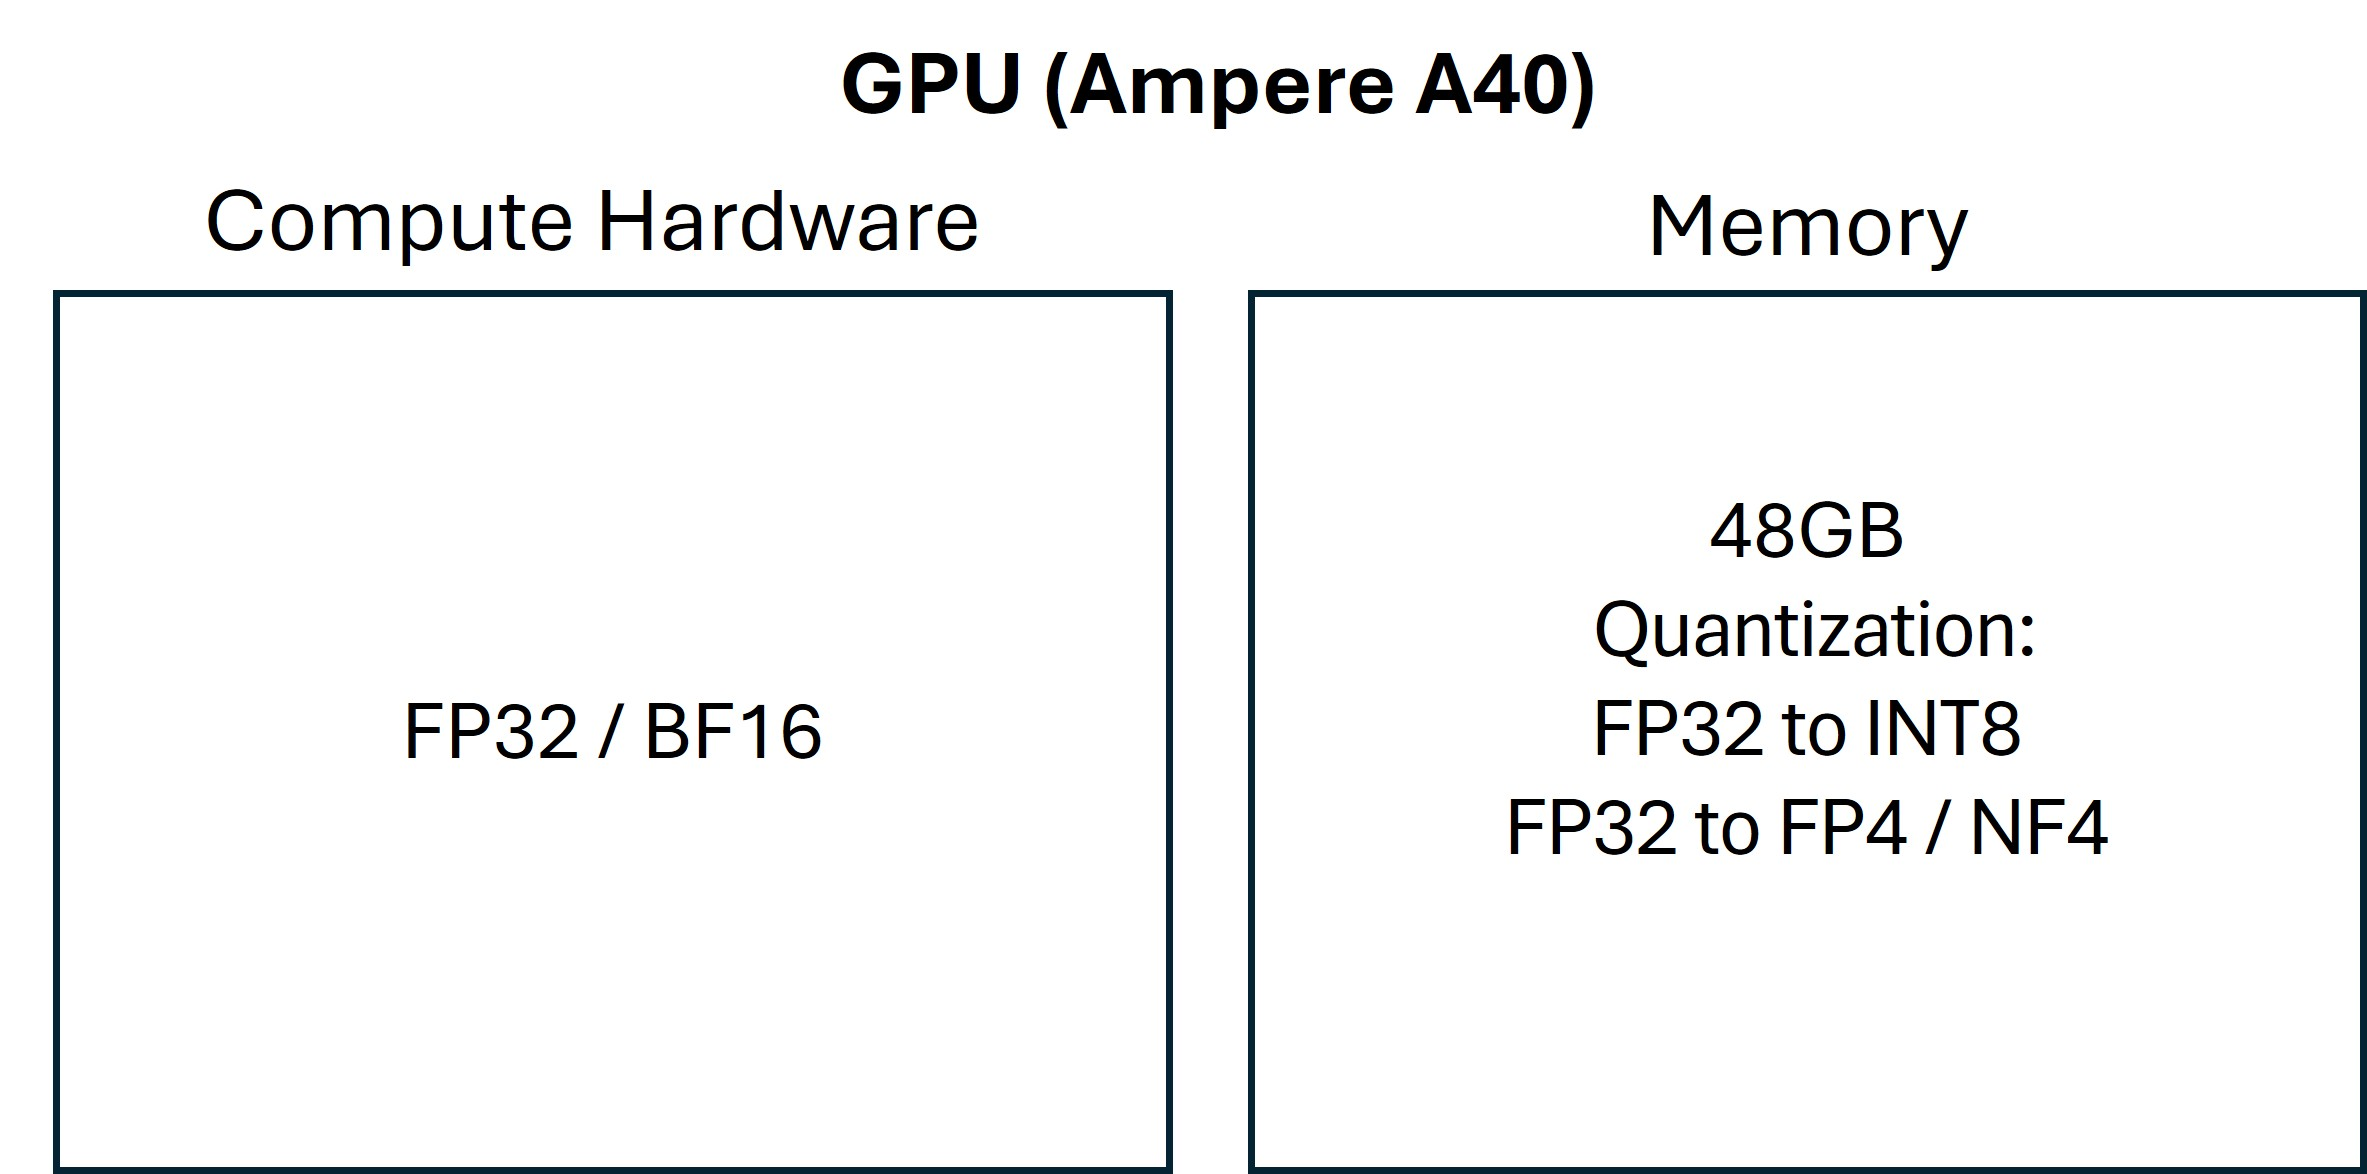

## Setup and Dependencies

First, we need to install the necessary libraries: `transformers` for accessing pre-trained models and `bitsandbytes` for 4-bit quantization.

As these features are available on the `main` branches only, we need to install the libraries below from source.

In [ ]:
# Install the required libraries
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Securely Load API Key
os.environ["HF_TOKEN"] = ""

## Basic Usage: Loading a Model with 4-bit Quantization

The `bitsandbytes` library seamlessly integrates with the Hugging Face `transformers` library, making it incredibly simple to load a model with 4-bit quantization. By simply adding the `load_in_4bit=True` argument to the `from_pretrained` method, you can load and convert a model to 4-bit precision on the fly.

Let's start with a relatively small model, `facebook/opt-350m`, to demonstrate the basic loading process.


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Define the model ID from the Hugging Face Model Hub
model_id = "facebook/opt-350m"

# Load the model with 4-bit quantization enabled
# device_map='auto' will automatically put the model on the GPU if available
model = AutoModelForCausalLM.from_pretrained(model_id, load_in_4bit=True, device_map="auto")

# Load the corresponding tokenizer for the model. The tokenizer is essential for encoding and decoding text.
tokenizer = AutoTokenizer.from_pretrained(model_id)

The model conversion technique is totally similar as the one presented in the [8 bit integration blogpost](https://huggingface.co/blog/hf-bitsandbytes-integration) - it is based on module replacement. If you print the model, you will see that most of the `nn.Linear` layers are replaced by `bnb.nn.Linear4bit` layers!

In [ ]:
print(model)

Once the model is loaded in 4-bit, you can use it for inference just like any other Hugging Face model. The quantization is handled internally by the `bitsandbytes` library.

In [ ]:
# Let's perform a simple text generation task to verify that the loaded and quantized model is working correctly.
text = "Hello my name is"
# Specify the device to perform inference on. "cuda:0" refers to the first GPU.
device = "cuda:0"

# Encode the input text using the tokenizer and move the resulting tensors to the specified device.
inputs = tokenizer(text, return_tensors="pt").to(device)

# Generate a sequence of tokens from the model based on the input.
# `max_new_tokens` limits the length of the generated text.
outputs = model.generate(**inputs, max_new_tokens=20)

# Decode the generated token IDs back into human-readable text and print the output.
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

## Advanced Usages: Customizing 4-bit Quantization

The `bitsandbytes` integration offers several advanced configuration options through the `BitsAndBytesConfig` class. These options allow you to fine-tune the quantization process and leverage additional features like different quantization types and compute data types for potentially better performance or accuracy.

To use these advanced options, you need to create an instance of `BitsAndBytesConfig` and pass it to the `quantization_config` argument in the `from_pretrained` method. Remember to always set `load_in_4bit=True` within the `BitsAndBytesConfig` when you intend to load a 4-bit quantized model.

### Changing the Compute Dtype

The `bnb_4bit_compute_dtype` parameter in `BitsAndBytesConfig` allows you to specify the data type used for computations within the 4-bit layers. While the model weights are stored in 4-bit, the actual matrix multiplications can be performed in a higher precision format for improved numerical stability or performance.

By default, the compute dtype is `float32`. You can change it to `bfloat16` (Brain Floating Point) or `float16` (Half-Precision Floating Point) if your hardware supports it. `bfloat16` is often preferred for its wider dynamic range compared to `float16`, which can be beneficial for training and inference.


In [ ]:
import torch
from transformers import BitsAndBytesConfig

# Create a BitsAndBytesConfig object to specify the quantization settings.
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
# Load the model with the specified quantization configuration.
# The compute dtype will be used for the forward pass calculations.
model_cd_bf16 = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)

In [ ]:
# Run a prediction with the model loaded with bfloat16 compute dtype.
outputs = model_cd_bf16.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Changing the quantization type

The 4bit integration comes with 2 different quantization types: FP4 and NF4. The NF4 dtype stands for Normal Float 4 and is introduced in the [QLoRA paper](https://arxiv.org/abs/2305.14314)

You can switch between these two dtype using `bnb_4bit_quant_type` from `BitsAndBytesConfig`. By default, the FP4 quantization is used.


### Changing the Quantization Type

The 4bit integration comes with 2 different quantization types: `FP4` (Floating Point 4-bit) and `NF4` (Normal Float 4-bit).

- **FP4:** A standard floating-point representation.
- **NF4:** A novel 4-bit data type introduced in the [QLoRA paper](https://arxiv.org/abs/2305.14314). NF4 is an empirically derived data type that is information theoretically optimal for normally distributed data, which is often the case for pre-trained neural network weights. Using NF4 can sometimes lead to better results compared to FP4.

The default quantization type is `FP4`. You can switch to `NF4` using the `bnb_4bit_quant_type` parameter from `BitsAndBytesConfig`.


In [ ]:
from transformers import BitsAndBytesConfig

# Create a BitsAndBytesConfig object to specify NF4 quantization.
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
)

# Load the model with the NF4 quantization configuration.
model_nf4 = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=nf4_config)

In [ ]:
# Run a prediction with the model loaded using NF4 quantization.
outputs = model_nf4.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

### Combining all the features together

You can combine multiple advanced quantization features within a single `BitsAndBytesConfig` object. Let us assume you want to run a model with `nf4` as the quantization type, with nested quantization and using `bfloat16` as the compute dtype:


In [ ]:
import torch
from transformers import BitsAndBytesConfig

# Create a BitsAndBytesConfig object combining NF4 and bfloat16 compute dtype.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load the model with the combined quantization configuration.
model_4bit = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config)

In [ ]:
# Run a prediction with the model loaded using the combined configuration.
outputs = model_4bit.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

## Pushing the limits of Quantization

How far can we go using 4bit quantization? We'll see below that it is possible to load a 20B-scale model (40GB in half precision) entirely on the GPU using this quantization method! 🤯

Let's load the model with NF4 quantization type for better results, `bfloat16` compute dtype as well as nested quantization for a more memory efficient model loading.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Define the model ID for the large 20B parameter model.
model_id = "EleutherAI/gpt-neox-20b"

# Create a BitsAndBytesConfig with NF4 quantization and bfloat16 compute dtype, optimized for large models.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load the tokenizer for the large model.
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the large model with the specified 4-bit quantization configuration.
# `device_map="auto"` is crucial here to distribute the model layers across available devices.
model_4bit = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

Let's make sure we loaded the whole model on GPU

In [ ]:
model_4bit.hf_device_map

Once loaded, run a generation!

In [ ]:
text = "Hello my name is"

# Specify the device for inference.
device = "cuda:0"

# Encode the input text and move it to the device.
inputs = tokenizer(text, return_tensors="pt").to(device)

# Generate text using the 20B parameter model.
outputs = model_4bit.generate(**inputs, max_new_tokens=20)

# Decode and print the generated text.
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

As you can see, we were able to load and run the 4bit gpt-neo-x model entirely on the GPU

## Push Model to HuggingFace Hub (Optional)

If you have made modifications to the model (e.g., fine-tuning after loading in 4-bit) or simply want to save and share the 4-bit quantized version of a model, you can push it to the Hugging Face Hub.

**Note:** You need to be logged in to your Hugging Face account in your environment (e.g., using `huggingface-cli login` in your terminal or in a code cell) for this step to work.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Define the model ID of the base model (the one you loaded and potentially modified).
model_id = "facebook/opt-350m"

# Load the model and tokenizer again. You would do this if you were starting a new session
# or if you had performed operations on the model that you want to save.
model = AutoModelForCausalLM.from_pretrained(model_id, load_in_4bit=True, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
# Define model and repo details
model_name = "maven-opt-350m-4bit"  # Change to your desired model name
repo_name = f"large-traversaal/{model_name}"  # Change 'your_username' to your HF username

# Push to Hugging Face
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

# Conclusion

This notebook provided a guide to using `bitsandbytes` for 4-bit quantization with Hugging Face models.

**Key takeaways:**
* 4-bit quantization significantly reduces the memory footprint of large language models.
* This enables loading and running very large models (like 20B parameters) on hardware with limited VRAM.
* Integrates seamlessly with Hugging Face `transformers` and offers customization options.
* Makes large model inference and potentially fine-tuning more accessible.